# Exploratory Data Analysis and Initial Models

This notebook contains code for reading and reformatting data along with the code and results for a couple ad-hoc models. 

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reading Data

The `file_numbers` denotes the molecule excel spreadsheets that are to be read. This variable is also referenced later as a indexing list.

In [2]:
raw_loc_base = '../data/raw'
file_numbers = ['17', '19', '20','21','22','23','25','26','41','42','44','45']

In [3]:
master_name = 'Input information and X10 - X18.xlsx'
master_loc = os.path.join(raw_loc_base, master_name)
# Read the master file with X10-X18 variables and mappings between file_numbers and the sample
master = pd.read_excel(master_loc, sheet='inputs', header=0)

In [4]:
master.head()

,Input,Key,X10: Category Method,X11: Temperature (K),X12: [Salt*Valency],X13: Category Salt type,X14: [Buffer] (mM),X15: pH,X16: CI number,X17: CI,X18: CP,Output: logK
0,1,17,A,298,0,0,0,6.00,0,NaN,CP_3,4.39
1,2,17,B,298,0,0,50,4.74,0,NaN,NaN,4.39
2,3,19,A,298,0,0,0,6.00,1,CI_2,CP_3,4.63
3,4,20,A,298,0,0,0,6.00,2,CI_1,CP_3,4.80
4,5,21,A,298,0,0,0,6.00,2,CI_2,CP_3,4.90


The following block contains functions that read each sheet of the X1-X9 data mapped to from the `Key` column above and read from the `file_numbers` list. 

In [5]:
def read_X1(file_name, sheet_name='X1', col_names=['atom_number', 'AMU', 'x', 'y', 'z']):
    return pd.read_excel(file_name, sheet_name=sheet_name, header=None, names=col_names)
    
def read_X2(file_name, sheet_name='X2', col_name='occupied'):
    df = pd.read_excel(file_name, sheet_name=sheet_name, header=None)
    flat = df.values.flatten()
    return pd.Series(flat[~np.isnan(flat)]).rename(col_name)

def read_X2V(file_name, sheet_name='X2V', col_name='virtual'):
    df = pd.read_excel(file_name, sheet_name=sheet_name, header=None)
    flat = df.values.flatten()
    return pd.Series(flat[~np.isnan(flat)]).rename(col_name)

def read_X3(file_name, sheet_name='X3'):
    return pd.read_excel(file_name, sheet_name=sheet_name, header=None)

def read_X4(file_name, sheet_name='X4'):
    return pd.read_excel(file_name, sheet_name=sheet_name, header=None)

def read_X5(file_name, sheet_name='X5', col_names=['electric_potential', 'x', 'y', 'z']):
    return pd.read_excel(file_name, sheet_name=sheet_name, header=None, names=col_names)

def read_X6(file_name, sheet_name='X6', col_names=['XX', 'YY', 'ZZ', 'XY', 'XZ', 'YZ']):
    return pd.read_excel(file_name, sheet_name=sheet_name, header=None, names=col_names)

def read_X7(file_name, sheet_name='X7'):
    return pd.read_excel(file_name, sheet_name='X7', header=None)

def read_X8(file_name, sheet_name='X8', col_name='SCF'):
    df = pd.read_excel(file_name, sheet_name=sheet_name, header=None)
    flat = df.values.flatten()
    return pd.Series(flat[~np.isnan(flat)]).rename(col_name)
    
def read_X9(file_name, sheet_name='X9', col_name='MO'):
    df = pd.read_excel(file_name, sheet_name=sheet_name, header=None)
    flat = df.values.flatten()
    return pd.Series(flat[~np.isnan(flat)]).rename(col_name)

## Preprocessing

The following 10 code blocks read each sheet for each excel file and transforms the data into a much smaller vector representation. Many of the sheets are non-square matrices, so dimensionality reduction was performed by running Singular Value Decomposition (SVD) and taking a subset of the singular values. For sheets that are large vectors, the mean of the vector was used. Obviously, this preprocessing throws away a ton of information, but it was fast and easy to code up while taking little mental effort. We should think about ways to better retain the information about these variables in the future. 

Each sheet is stored in an array that holds the reformatted data for that variable for each file. These arrays are later used to transform these variables to matrices and are fed into learners. 

In [6]:
X1 = []
for num in file_numbers:
    x = read_X1(os.path.join(raw_loc_base, num+'.xlsx'))
    u,s,v = np.linalg.svd(x.values)
    X1.append(s)

In [7]:
X2 = []
for num in file_numbers:
    x = read_X2(os.path.join(raw_loc_base, num+'.xlsx'))
    X2.append(np.array(np.mean(x)))

In [8]:
X2V = []
for num in file_numbers:
    x = read_X2V(os.path.join(raw_loc_base, num+'.xlsx'))
    X2V.append(np.array(np.mean(x)))

In [9]:
X3 = []
cutoff = 5
for num in file_numbers:
    x = read_X3(os.path.join(raw_loc_base, num+'.xlsx'))
    u,s,v = np.linalg.svd(x.values)
    X3.append(s[:cutoff])

In [10]:
X4 = []
for num in file_numbers:
    x = read_X4(os.path.join(raw_loc_base, num+'.xlsx'))
    u,s,v = np.linalg.svd(x.values)
    X4.append(s)

In [11]:
X5 = []
for num in file_numbers:
    x = read_X5(os.path.join(raw_loc_base, num+'.xlsx'))
    u,s,v = np.linalg.svd(x.values)
    X5.append(s)

In [12]:
X6 = []
cutoff = 5
for num in file_numbers:
    x = read_X6(os.path.join(raw_loc_base, num+'.xlsx'))
    try:
        u,s,v = np.linalg.svd(x.values)
        X6.append(s[:cutoff])
    except Exception:
        X6.append(np.zeros(shape=(cutoff)))
    

In [13]:
X7 = []
for num in file_numbers:
    x = read_X7(os.path.join(raw_loc_base, num+'.xlsx'))
    try:
        u,s,v = np.linalg.svd(x.values)
        X7.append(s)
    except Exception:
        X7.append(np.zeros(shape=(3)))

In [14]:
X8 = []
for num in file_numbers:
    x = read_X8(os.path.join(raw_loc_base, num+'.xlsx'))
    X8.append(np.array(np.mean(x)))

In [15]:
X9 = []
for num in file_numbers:
    x = read_X9(os.path.join(raw_loc_base, num+'.xlsx'))
    X9.append(np.array(np.mean(x)))

In [16]:
# Combine all sheet variables into list
XS = [X1, X2, X2V, X3, X4, X5, X6, X7, X8, X9]

In [17]:
y = master['Output: logK']
y.head()

0    4.39
1    4.39
2    4.63
3    4.80
4    4.90
Name: Output: logK, dtype: float64

In [18]:
# drop the output, input columns
master_drop = master.drop(['Output: logK', 'Input'], axis=1)

In [19]:
# Break out categorical variables with dummy columns
X = pd.get_dummies(master_drop)

## Learning Algorithms

This section throws a few learning algorithms at the data. Specifically, we use linear regression and regression trees. The dataset is incredibly small, so we use the mean scores from 5-fold cross-validation as "results".

For the first run, only the master sheet (X10-X18) is used as an input for the algorithms. For the second run, only the X1-X9 variables are used. The final run concatenates both datasets together for a total of 28 examples with 41 columns each.

C:\Users\mitadm\Miniconda2\envs\py27\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mitadm\Miniconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


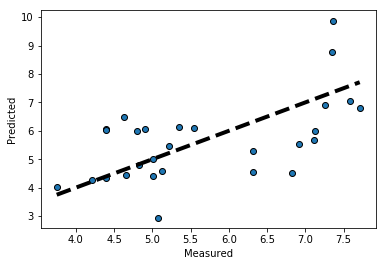

In [21]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

lr = linear_model.LinearRegression()
scaler = preprocessing.StandardScaler().fit(X)
X_transformed = scaler.transform(X)
predicted = cross_val_predict(lr, X_transformed, y, cv=10)


fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [22]:
scores = cross_val_score(lr, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), scores.std() * 2))

MSE: 10.09 (+/- 34.97)


In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
regr_1 = DecisionTreeRegressor(max_depth=2)

scores = cross_val_score(regr_1, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), scores.std() * 2))

MSE: 1.77 (+/- 0.97)


In [24]:
regr_2 = DecisionTreeRegressor(max_depth=5)

scores = cross_val_score(regr_2, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), scores.std() * 2))

MSE: 1.36 (+/- 1.30)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y.values, test_size=0.1, random_state=0)
print(X_train.shape[0],X_test.shape[0])

(25, 3)


In [26]:
regr_2.fit(X_train, y_train)
y_pred = regr_2.predict(X_test)

print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))

MSE: 1.18941066667


In [27]:
all_cols = []
for idx, row in master_drop.iterrows():
    indexof = file_numbers.index(str(row['Key']))
    cols = None
    for feature in XS:
        if cols is None:
            cols = feature[indexof]
        else:
            if feature[indexof].shape:
                cols = np.concatenate((cols, feature[indexof]))
    all_cols.append(cols)

In [28]:
more_data = pd.DataFrame(all_cols)
X_more = more_data.values

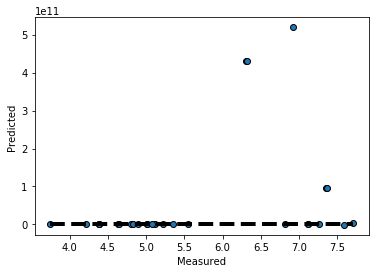

In [29]:
lr = linear_model.LinearRegression()
scaler = preprocessing.StandardScaler().fit(X_more)
X_more_transformed = scaler.transform(X_more)
predicted_more = cross_val_predict(lr, X_more_transformed, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted_more, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [30]:
scores = cross_val_score(lr, X_more_transformed, y, cv=5, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), scores.std() * 2))

MSE: 4.67 (+/- 8.06)


In [31]:
regr_1 = DecisionTreeRegressor(max_depth=2)

scores = cross_val_score(regr_1, X_more_transformed, y, cv=5, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), scores.std() * 2))

MSE: 3.37 (+/- 4.72)


In [32]:
regr_2 = DecisionTreeRegressor(max_depth=5)

scores = cross_val_score(regr_2, X_more_transformed, y, cv=5, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), scores.std() * 2))

MSE: 3.20 (+/- 4.66)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_more_transformed, y.values, test_size=0.1, random_state=0)
regr_2.fit(X_train, y_train)
y_pred = regr_2.predict(X_test)

print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))

MSE: 1.201025


In [34]:
X_combined = np.hstack((X_transformed, X_more_transformed))
X_combined.shape

(28, 41)

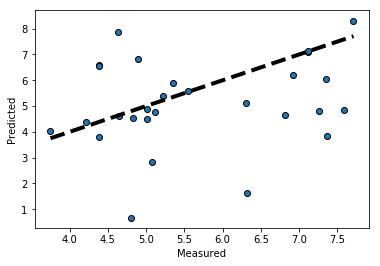

In [35]:
lr = linear_model.LinearRegression()
predicted_combined = cross_val_predict(lr, X_combined, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted_combined, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [36]:
scores = cross_val_score(lr, X_combined, y, cv=5, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), scores.std() * 2))

MSE: 3.30 (+/- 5.81)


In [37]:
regr_1 = DecisionTreeRegressor(max_depth=2)

scores = cross_val_score(regr_1, X_combined, y, cv=5, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), scores.std() * 2))

MSE: 1.93 (+/- 0.91)


In [38]:
regr_2 = DecisionTreeRegressor(max_depth=5)

scores = cross_val_score(regr_2, X_combined, y, cv=5, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), scores.std() * 2))

MSE: 1.30 (+/- 1.42)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y.values, test_size=0.1, random_state=0)
regr_2.fit(X_train, y_train)
y_pred = regr_2.predict(X_test)

print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))

MSE: 3.15161851852


## Conclusion

This was a quick and dirty attempt at using machine learning to predict the logK values. None of the results should be considered statistically significant. The first run with just the X10-X18 variables actually performs the best, likely because it contains the most information. The condensed X1-X9 data loses a lot of information in the process, so the machine learning algorithms probably can't parse it out well enough, at least not with only 28 samples, so the second run doesn't perform well (about as accurate as guessing the logK value randomly). Expectedly, combining all the varaiables in the final run returns results that are between the two other runs. 

There are many routes for future work. The first thing would be to find a better matrix and vector normalization method that does not destroy so much information while still keeping the dimensionality reasonably low. If there were thousands of spreadsheets like '17.xlsx' and '19.xlsx' etc., we could train an neural network to learn a mapping of each of these X1-X9 to a smaller vector space. Another method might be in trying to categorize these X1-X9 and then use the category to describe the input instead of the raw data. 

We can also try different algorithms in the future, especially if we get more data in the future. 

In [40]:
results = []
for i in range(X_combined.shape[0]):
    result = {'logK' : y[i], 'sample' : i+1}
    yhat = np.delete(y.values, i)
    
    # Combined X1-X18
    dt_combined = DecisionTreeRegressor(max_depth=2)
    lr_combined = linear_model.LinearRegression()
    Xhat = np.delete(X_combined, i, axis=0)
    dt_combined.fit(Xhat, yhat)
    lr_combined.fit(Xhat, yhat)
    result['regression_tree_X1-X18'] = dt_combined.predict(X_combined[i,:].reshape(1,-1))[0]
    result['linear_regression_X1-X18'] = lr_combined.predict(X_combined[i,:].reshape(1,-1))[0]
    
    # X1-X9
    dt_more = DecisionTreeRegressor(max_depth=2)
    lr_more = linear_model.LinearRegression()
    Xhat = np.delete(X_more_transformed, i, axis=0)
    dt_more.fit(Xhat, yhat)
    lr_more.fit(Xhat, yhat)
    result['regression_tree_X1-X9'] = dt_more.predict(X_more_transformed[i,:].reshape(1,-1))[0]
    result['linear_regression_X1-X9'] = lr_more.predict(X_more_transformed[i,:].reshape(1,-1))[0]
    
    # X10-X18
    dt = DecisionTreeRegressor(max_depth=2)
    lr = linear_model.LinearRegression()
    Xhat = np.delete(X_transformed, i, axis=0)
    dt.fit(Xhat, yhat)
    lr.fit(Xhat, yhat)
    result['regression_tree_X10-X18'] = dt.predict(X_transformed[i,:].reshape(1,-1))[0]
    result['linear_regression_X10-X18'] = lr.predict(X_transformed[i,:].reshape(1,-1))[0]
    
    results.append(result)    

In [41]:
results_df = pd.DataFrame(results)
results_df.head()

,linear_regression_X1-X18,linear_regression_X1-X9,linear_regression_X10-X18,logK,regression_tree_X1-X18,regression_tree_X1-X9,regression_tree_X10-X18,sample
0,4.400000,4.390000e+00,4.912421,4.39,5.792308,4.606667,5.792308,1
1,4.380000,4.390000e+00,5.777148,4.39,5.792308,4.606667,5.792308,2
2,7.701589,1.221479e+11,6.645057,4.63,6.067778,4.526667,6.067778,3
3,0.787505,7.845815e+00,5.326271,4.80,6.048889,5.262143,6.048889,4
4,6.797545,-4.709680e+11,5.688477,4.90,6.060000,6.060000,6.037778,5


In [54]:
results_df.to_excel('../data/results/leave_one_out.xlsx')